In [1]:
%load_ext autoreload
%autoreload 2

**Scope of this notebook**

This notebook provides the general workflow to train and validate an ML DOS model in silicon dataset based on sparse Gaussian process regression, as described in Ben Mahmoud et al. (PRB 2020). We show how to build models for the 3 representations of the DOS: 
* pointwise (PW)
* PC decomposition (PC) 
* cumulative distribution function (CDF). 

The second part deals with the derived quantities from the DOS, like the band energy, Fermi energy (or chemical potential), the value of the DOS at the Fermi energy, and the excitation distribution. We also show how to obtain the "local charges" from the local DOS.


*NB: All the helper functions can be examined in the ``utils`` folder.*

Before we start we go through a **few necessary defintions**

1. *What is the electronic density of states (DOS)?* We place ourselves within the quasi-particle description of the electron system (like in density functional theory DFT), and describe the DOS as the sum of the single-particle eigenenergies describing the the energy levels $E_n(\mathbf{k})$ that are accessible to the electrons at each point **k** of the Brioullin zone:
$$\mathrm{DOS}(E) = \frac{2}{N_k} \sum_n^{bands} \sum_\mathbf{k} \delta(E-E_n(\mathbf{k}))$$
We assume that energy levels are spin-degenerate.
In practise we replace the $\delta$ function by a Gaussian broadening function of a width $g_b$
<br></br>
1. *What is the ML DOS model?* We use an atom-centred model for the DOS($A$, $E$), where we decompose the global DOS of a structure $A$ into LDOS contributions from its different atomic environemnts :
$$\mathrm{DOS}(A, E) = \sum_{A_i \in A} \mathrm{LDOS}(A_i, E)$$
To make notation slightly easier to follow, we drop the $A$ from the expressions. Along this notebook we discuss the 3 strategy that we employ to model this quantity using kernels models.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ase
import ase.io as ase_io

from tqdm.notebook import tqdm, tnrange

import rascal
from rascal.models import Kernel, KRR, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import dump_obj, load_obj, FPSFilter

from utils import *

from time import time

# loading data

In [5]:
# loading the training frames
frames = ase_io.read("../data/traininig_dataset.xyz", ":")

# get the total number of structures
ntot = len(frames)

In [6]:
for frame in frames:
    frame.wrap(eps=1e-12)

In [7]:
# get the number of atoms in each structure
natoms = np.zeros(ntot, dtype=int)
for i in range(ntot):
    natoms[i] = len(frames[i])

Details about the DFT calculation on the dataset can be found on the PRB 2020 paper, and in the published dataset file on ``materialscloud``. Here we grouped the eigenenergies in a single json file so it can be loaded easily in a human readable format.

*NB: as a general rule, the DOS requires a denser k-point grid to obtain a converged quantity than the total energy or the forces for example. Also, the k-point density should be the same for all the structures in the training set*

In [ ]:
# load eigenenergies
with open("../data/train_energies.json") as f:
    eigen_energies = json.load(f)
print(eigen_energies["info"])

In [9]:
# unpack eigenenergies
energies = []
for i in range(ntot):
    dd = []
    tmp = eigen_energies["%d"%i]["kpoints"]
    for key in tmp.keys():
        dd.append(tmp[key])
    energies.append(np.array(dd))

In [10]:
# determine the minimum and maximum energies
emin = np.min(np.array([np.min(energies[i]) for i in range(len(energies))]))
emax = np.max(np.array([np.max(energies[i]) for i in range(len(energies))]))

In [11]:
print("Emin = {:.3f}eV\nEmax = {:.3f}eV".format(emin, emax))

Emin = -24.554eV
Emax = 11.346eV


In [12]:
# choosing the DOS Gaussian boroadening and energy grid spacing
gb = 0.3 #eV
dE = 0.05 #eV

The ``build_dos`` function builds a DOS that is normalized by the number of atoms in the each structure.

In [13]:
# build the DOS of the dataset
xdos, ldos = build_dos(gb, energies, dE, emin, emax, natoms)

We explicitely account for the spin-degeneracy because we the output of FHI-aims does not provide duplicated eigenenergies.

In [14]:
ldos *= 2.

In [15]:
# compute the mean DOS on the training set
mean_dos_per_atom = ldos.mean(axis=0)

# Build the model

In [16]:
# train/test splits: we use 80/20
np.random.seed(0) 
ntrain = int(0.8 * ntot) 
itrain = np.arange(ntot) 
np.random.shuffle(itrain) 
itest = itrain[ntrain:] 
itrain = itrain[:ntrain] 
print("number of training structures = {}".format(ntrain))

number of training structures = 831


We use ``librascal`` to handle the atomic representation generation. These hyperparamters were optimised for the binding energy of silicon in the dataset. 

In [17]:
# SOAP hypers
HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': 4.,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.45,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'normalize' : True,
    'cutoff_function_type': 'RadialScaling',
    'cutoff_function_parameters': {'rate': 1,
        'scale': 3.,
        'exponent': 5,
        'interaction_cutoff': 4.,
        'cutoff_smooth_width': 0.5},
}
soap = SphericalInvariants(**HYPERS)

In [18]:
# perpare the SOAP representation for the structures in the training set
## this part can be slow
start = time()
managers = soap.transform(frames)
print ("Execution: ", time()-start, "s")

Execution:  0.711082935333252 s


**A few words about the sparse GPR used here**

To build all the ML models in this notebook, we use the sparse GPR as the ML algorithm of choice. We need to select the ``nref`` atomic environments that we will use to define the basis on which we expand the LDOS:
$$\mathrm{LDOS}(A_i, E) = \sum_{j}^{\text{nref}} x_j(E) k(A_i, M_j),$$
where where $k(A_i, M_j)$ is a positive-definite kernel basis function that expresses the similarity between the environment $A_i$ and an environment from the active set $M_j$. The active set is selected according to the furthest point sampling (FPS) algorithm.

The kernel function $k(A_i, M_j)$ that we use here is defined as a dot product between the two SOAP vectors with a certain exponent ``zeta``, usually taken to be ``2``. The ``Kernel`` module of ``librascal`` handles building the vector of kernels of each structures as the sum of the kernels of the local atomic environments. We refer to this object as $K_{NM}$

In the previous expression, we need to determine the matrix of weights $\mathbf{x}(E)$. It is given by the following expression:
$$ \mathbf{x}(E) = (\lambda^2 K_{MM} + K_{NM}^TK_{NM})^{-1} K_{NM}^T \mathbf{y}(E),$$
where $\lambda$ is the regularization parameter that we need to optimize, $K_{MM}$ is the kernel matrix of the active set, and $\mathbf{y}(E)$ is a vector containing the DOS(E) of all the structures in the training set at the energy grid $E$.

Once the model is trained, the ML DOS of any structure is simply the dot product between the weights matrix and the kernel vector:
$$\mathrm{DOS}(E) = \mathbf{x}(E) k(A, M)$$

In [19]:
# get the sparse environments
## this part can be slow depending on nref

nref = 1000
n_sparse = {14: nref}
compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers)

In [20]:
# define a kernel
zeta = 2 # exponent of the kernel
kernel = Kernel(soap,
                name="GAP",
                kernel_type="Sparse",
                target_type="Structure",
                zeta=zeta)

In [21]:
# get the kNM
kNM = kernel(managers, X_sparse, grad=(False, False))

In [22]:
# get kMM
kMM = kernel(X_sparse)

The ``Kernel`` modele builds kernels that are not normalized by the number of the atoms in each structures, which may create problems with normalized DOS. Two rational choices appear here:
1. scale the DOS by the number of atoms
1. normalize $K_{NM}$ by the number of atoms

In [23]:
## scale the DOS with the number of atoms

scale_dos = True #set to True for the first strategy and False for the second

if scale_dos:
    for j in range(ntot):
        ldos[j] *= natoms[j]
    scaling_mean = natoms

else:
    for j in range(ntot):
        kNM[j] /= natoms[j]
    scaling_mean = np.ones(len(ldos))

# PW model

In the pointwise (PW) represenatation we propose to build model for the discretized DOS as built earlier in the notebook. Building a different sparse GPR model for each energy channel $E$ results in choosing different regularization values. This strategy may lead to obtaining a non-smooth ML DOS. This is why we opt to have a single value for $\lambda$ for all the energy channels, ensuring that the ML DOS is continuous. By examining the expression for the predicted DOS, we notice that the only quantity that may break the smoothness condition is $\lambda$.

The optimization process to find $\lambda$ uses n-fold cross validation (CV). For this particualr dataset, 2-fold CV is enough to find the optimal $\lambda$.

In [24]:
# N-fold cross-validation
cv = 2 # number of folds

Usually, we remove the mean of the training set from the targets, but this step is not necessary if we opt the point of view of the kernel ridge regression.

In [25]:
mean_pw = np.zeros(ldos.shape)
for j in range(len(mean_pw)):
    mean_pw[j] = mean_dos_per_atom * scaling_mean[j]
train_target = ldos - mean_pw

Optimization step and obtainment of the weights matrix.

In [26]:
weights_pw = train_model(train_target[itrain], 
                      kNM[itrain], 
                      kMM, 
                      cv=2, 
                      xdos=xdos, 
                      maxiter=8, 
                      i_regularization=1e-9)

 final_simplex: (array([[-22.27751077],
       [-22.26132072]]), array([15.93451912, 15.93460084]))
           fun: 15.93451911910552
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 8
        status: 2
       success: False
             x: array([-22.27751077])
2.1134890398366395e-10
(831, 778)


## Validation of the model

In [27]:
# build the predicted ML DOS
ldos_pred_pw = kNM @ weights_pw + mean_pw

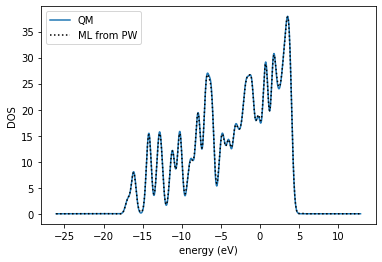

In [28]:
ii = itest[-1]

plt.plot(xdos, ldos[ii], label="QM")
plt.plot(xdos, ldos_pred_pw[ii], "k:", label="ML from PW")

plt.xlabel("energy (eV)")
plt.ylabel("DOS")

plt.legend()
plt.show()

In [29]:
print("errors of the CDF representation")
print()
print("RMSE = {:.3f} (1/eV)".format(get_rmse(ldos_pred_pw[itest], ldos[itest], xdos, perc=False)))
print("%RMSE = {:.3f}%".format(get_rmse(ldos_pred_pw[itest], ldos[itest], xdos, perc=True)))

errors of the CDF representation

RMSE = 1.902 (1/eV)
%RMSE = 3.828%


# CDF model

We define the cumulative distribution function (CDF) of the DOS as:
$$\mathrm{CDF}{E} = \int^E \mathrm{DOS}(\epsilon) \mathrm{d}\epsilon$$
By learning the CDF first and then computing its derivative (using the central formula for the first derivative to get the DOS), we "teach" the ML model that adjacent points on the energy grid are NOT independent.

We propose to build the same sparse GPR models as the PW representation. 

In [42]:
lcdf = ldos.cumsum(axis=1)

In [43]:
# N-fold cross-validation
cv = 2 # number of folds

In [46]:
mean_cdf = np.zeros(ldos.shape)
for j in range(len(mean_cdf)):
    mean_cdf[j] = mean_dos_per_atom.cumsum() * scaling_mean[j]
train_target = lcdf - mean_cdf

In [47]:
weights_cdf = train_model(train_target[itrain], 
                      kNM[itrain], 
                      kMM, 
                      cv=2, 
                      xdos=xdos, 
                      maxiter=8, 
                      i_regularization=1e-1)

 final_simplex: (array([[-4.72029944],
       [-4.60517019]]), array([4.57918303, 4.57992677]))
           fun: 4.5791830267468265
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 16
           nit: 8
        status: 2
       success: False
             x: array([-4.72029944])
0.008912509381337464
(831, 778)


## Validation of the model

In [48]:
lcdf_pred = kNM @ weights_cdf + mean_cdf

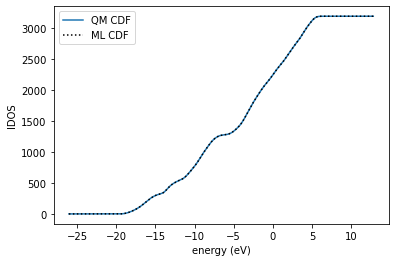

In [49]:
ii = itest[0]

plt.plot(xdos, lcdf[ii], label="QM CDF")
plt.plot(xdos, lcdf[ii], "k:", label="ML CDF")

plt.xlabel("energy (eV)")
plt.ylabel("IDOS")

plt.legend()
plt.show()

In [54]:
print("errors in the CDF")
print()
print("RMSE = {:.3f}".format(get_rmse(lcdf_pred, lcdf, xdos, perc=False)))
print("%RMSE = {:.3f}%".format(get_rmse(lcdf_pred, lcdf, xdos, perc=True)))

errors in the CDF

RMSE = 22.822
%RMSE = 0.146%


In [51]:
## get the central derivative
pred = (lcdf_pred[:, 2:] - lcdf_pred[:, :-2]) / 2.

## add zeros to the beginning and the end of every predicted DOS
ldos_pred_cdf = []
for x in pred:
    y = [0] + x.tolist() + [0]
    ldos_pred_cdf.append(y)
ldos_pred_cdf = np.array(ldos_pred_cdf)

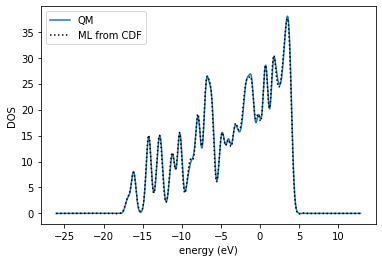

In [52]:
ii = itest[1]
plt.plot(xdos, ldos[ii], label="QM")
plt.plot(xdos, ldos_pred_cdf[ii], "k:", label="ML from CDF")

plt.xlabel("energy (eV)")
plt.ylabel("DOS")

plt.legend()
plt.show()

In [56]:
print("errors of the CDF representation")
print()

print("RMSE = {:.3f} (1/eV)".format(get_rmse(ldos_pred_cdf[itest], ldos[itest], xdos, perc=False)))
print("%RMSE = {:.3f}%".format(get_rmse(ldos_pred_cdf[itest], ldos[itest], xdos, perc=True)))

errors of the CDF representation

RMSE = 2.095 (1/eV)
%RMSE = 4.218%


# PC decomposition

We define the PC representation as the projection coefficients of the DOS(E) in basis made of the principal components of the DOS of the traning structure. Then we build a sparse GPR model for each projection coefficient. 

This representation is interesting because:
1. the resulting ML DOS is always smooth because it is a linear combination of smooth functinos (the principal components)
1. due to the truncation process, the effect on the DOS can be seen as extra smoothing

In [74]:
n_pc = 10 #number of componenets to keep
_, doseve = build_pc(ldos[itrain], mean_pw[itrain], n_pc=n_pc)

Variance covered with 10 PCs is = 0.9927075571696384


In [75]:
coeffs = build_coeffs(ldos - mean_pw, doseve)

notice the resuduals due to the truncation of the PCs

In [76]:
trunc_dos = build_truncated_dos(doseve,
                                coeffs,
                                #ldos[itrain].mean(axis=0),
                                mean_pw,
                                n_pc=n_pc)

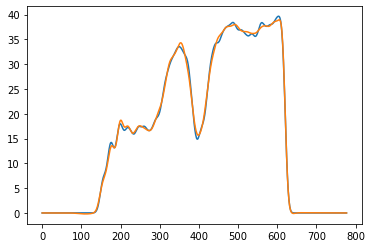

In [77]:
ii = -1

plt.plot(ldos[ii])
plt.plot(trunc_dos[ii])

In [78]:
print("truncation errors")
print()
print("RMSE = {:.3f} (1/eV)".format(get_rmse(trunc_dos, ldos, xdos, perc=False)))
print("%RMSE = {:.3f}%".format(get_rmse(trunc_dos, ldos, xdos, perc=True)))

truncation errors

RMSE = 1.755 (1/eV)
%RMSE = 3.445%


In [79]:
weights_pc = []

for i in tnrange(n_pc):
    train_target = coeffs[:, i]
    w = train_model(train_target[itrain], 
                      kNM[itrain], 
                      kMM, 
                      cv=2, 
                      xdos=None, 
                      maxiter=8, 
                      i_regularization=1e-5)
    weights_pc.append(w)
weights_pc = np.array(weights_pc)

  0%|          | 0/10 [00:00<?, ?it/s]

 final_simplex: (array([[-6.76384371],
       [-6.90775528]]), array([2.47960203, 2.48371906]))
           fun: 2.4796020336897406
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 16
           nit: 8
        status: 2
       success: False
             x: array([-6.76384371])
0.0011547819846894783
(831,)
 final_simplex: (array([[-8.85056145],
       [-8.88653934]]), array([14.96646475, 15.13867507]))
           fun: 14.966464753603221
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 17
           nit: 8
        status: 2
       success: False
             x: array([-8.85056145])
0.00014330125702369747
(831,)
 final_simplex: (array([[-11.72879282],
       [-11.8007486 ]]), array([22.27113451, 22.30358034]))
           fun: 22.27113450998837
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 16
           nit: 8
        status: 2
       success: False
             x: array([-11.72879282])
8.

In [81]:
pred_coeffs = kNM @ weights_pc.T

In [82]:
ldos_pred_pc = build_truncated_dos(doseve,
                                pred_coeffs,
                                mean_pw,
                                n_pc=n_pc)

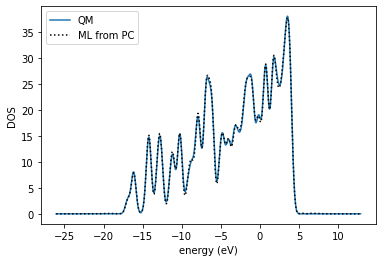

In [83]:
ii = itest[1]
plt.plot(xdos, ldos[ii], label="QM")
plt.plot(xdos, ldos_pred_pc[ii], "k:", label="ML from PC")

plt.xlabel("energy (eV)")
plt.ylabel("DOS")

plt.legend()
plt.show()

In [84]:
print("RMSE = {:.3f}".format(get_rmse(ldos_pred_pc[itest], ldos[itest], xdos, perc=False)))
print("%RMSE = {:.3f}%".format(get_rmse(ldos_pred_pc[itest], ldos[itest], xdos, perc=True)))

RMSE = 2.151
%RMSE = 4.330%


# Derived quantities

In this part, we propose to show how to build some derived quantities from the ML (L)DOS. Mainly, we will focus on:
1. the chemical potential (or Fermi level) $\mu$ at a temperature T: we obtain $\mu$ from the charge neutrality condition: 
$$\int \mathrm{DOS}(E) f_{FD}(E, \mu, T) \mathrm{d}E = N_{el},$$
where $f_{FD}(E, \mu, T)$ is the Fermi-Dirac distribution and $N_{el}$ is the number of electrons in the system. <br></br>*NB: be careful when dealing with scaled and non-scaled DOS!*
<br></br>
1. the band energy $\epsilon_b(T) = \int E\mathrm{DOS}(E) f_{FD}(E, \mu, T)\mathrm{d}E$
<br></br>
1. the value of the DOS at $\mu$
1. the distribution of the excitation $A(\Delta) = \int \int\mathrm{d}E \mathrm{d}E^\prime \mathrm{DOS}(E) f_{FD}(E, \mu, T=0) [\mathrm{DOS}(E^\prime) (1 - f_{FD}(E^\prime, \mu, T=0))] \delta(E-E^\prime-\Delta)$
1. **specific to ML DOS:** the local atomic charges: they are defined from the LDOS on each structure and using the global Fermi level of the structure:
$$q(A_i) = N_{el} - \int^\mu \mathrm{LDOS}(A_i, E) \mathrm{d}E$$

**NB:** In this notebook, and due to the numerical inaccuracies due to the integration of the Fermi-Dirac distribution at T=0, we use a small fictitious temperature T=200K, that is a good approximation of the T=0 behavior of the electrons

**NB:** In the following we show all the examples using the ML PW representation

In [30]:
T_0 = 200
beta_0 = 1 / (ase.units.kB * T_0) # inverse temperature

In [31]:
# number of electrons in each srtucture
Nel = np.zeros(len(ldos))
nel = 4. # number of valence electrons of silicon per atom
for j in range(len(Nel)):
    Nel[j] = nel * scaling_mean[j]

In [32]:
# Fermi level
efermi = np.zeros(ntot)
for i in tnrange(ntot):
    efermi[i] = getmu(ldos_pred_pw[i], beta_0, xdos, n=Nel[i])

  0%|          | 0/1039 [00:00<?, ?it/s]

In [33]:
## band energy at Tel = 0K
eband = np.zeros(ntot)
for i in tnrange(ntot):
    eband[i] = get_band_energy(ldos_pred_pw[i], efermi[i], xdos, beta_0)

  0%|          | 0/1039 [00:00<?, ?it/s]

In [34]:
## the value of the DOS at the Fermi level
dosfermi = np.zeros(ntot)
for i in range(ntot):
    dosfermi[i] = get_dos_fermi(ldos_pred_pw[i], efermi[i], xdos)

In [37]:
## distribution of the excitations
aofd = np.zeros(ldos.shape)
for i in range(ntot):
    aofd[i] = get_aofd(ldos_pred_pw[i], efermi[i], xdos, beta_0)

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

The local charges are defined from the LDOS. In order to obtain the LDOS, let's recall the expression of the ML DOS and how it relates to the LDOS:
$$\mathrm{DOS}(E) = \mathbf{x}(E) k(A, M),$$
where 
$$k(A, M) = \sum_{A_i \in A} k(A_i, M).$$
So, we can write the LDOS as a function of the same regression weights as the DOS:
$$\mathrm{LDOS}(A_i, E) = \mathbf{x}(E) k(A_i, M).$$
The $k(A_i, M)$ can be obtained easily from the ``Kernel`` module of ``librascal``. 

In [38]:
k_ai = Kernel(soap,
                name="GAP",
                kernel_type="Sparse",
                target_type="Atom",
                zeta=zeta)

In [39]:
local_kernels = k_ai(managers, X_sparse, grad=(False, False))

``local_kernels`` contains all the local kernels $k(A_i, M)$ present in the dataset

In [44]:
LDOS = [] 
k = 0
for i in range(ntot):
    LDOS.append(local_kernels[k: k+ natoms[i]] @ weights_pw + mean_pw[i] / scaling_mean[i])
    k += natoms[i]

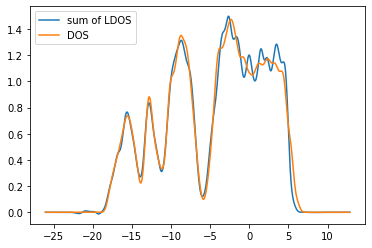

In [52]:
ii = 0
plt.plot(xdos, LDOS[ii].sum(axis=0), label="sum of LDOS")
plt.plot(xdos, ldos[ii], label="DOS")

plt.legend()

In [54]:
local_charges = []
for i in range(ntot):
    local_charges.append(get_charge(LDOS[i], efermi[i], xdos, beta_0, nel))

Don't forget to visualize the local charges! You can use ``Chemiscope`` to do so!